# FINE-TUNING DE VGG16

# Imports, paramètres et configurations

In [ ]:
import os
import random
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import vgg16, VGG16_Weights

from tqdm.auto import tqdm

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# ===== CONFIG =====
SEED = 42
data_dir = "First_Trial"
IMAGE_SIZE = 224
BATCH_SIZE = 16

TRAIN_SPLIT = 0.8
VAL_SPLIT   = 0.1
TEST_SPLIT  = 0.1

NUM_EPOCHS = 20
LR = 3e-4
WEIGHT_DECAY = 1e-4

FINETUNE_MODE = "full"  # "head_only" ou "full"
FREEZE_FEATURES = False
UNFREEZE_LAST_N_LAYERS = 0  # (option) dégeler seulement les derniers layers conv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(SEED)

Device: cpu


# Dataset et robustesse

In [8]:
class FilteredImageFolder(ImageFolder):
    """Ignore les dossiers vides + skip images corrompues."""
    def find_classes(self, directory):
        classes = [
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
            and len(os.listdir(os.path.join(directory, d))) > 0
        ]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            img = Image.open(path).convert("RGB")
        except (OSError, ValueError):
            new_index = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(new_index)

        if self.transform is not None:
            img = self.transform(img)
        return img, target

# Data Preparation et Data Augmentation

In [9]:
weights = VGG16_Weights.DEFAULT

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
    ),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Chargement du dataset : Train / Validation / Test - 80 / 20 / 20

In [10]:
full_dataset_train = FilteredImageFolder(root=data_dir, transform=train_transform)
full_dataset_eval  = FilteredImageFolder(root=data_dir, transform=eval_transform)

class_names = full_dataset_train.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total images:", len(full_dataset_train))

N = len(full_dataset_train)
train_size = int(TRAIN_SPLIT * N)
val_size   = int(VAL_SPLIT * N)
test_size  = N - train_size - val_size

generator = torch.Generator().manual_seed(SEED)
train_idx, val_idx, test_idx = random_split(
    range(N),
    [train_size, val_size, test_size],
    generator=generator
)

train_dataset = torch.utils.data.Subset(full_dataset_train, train_idx.indices)
val_dataset   = torch.utils.data.Subset(full_dataset_eval,  val_idx.indices)
test_dataset  = torch.utils.data.Subset(full_dataset_eval,  test_idx.indices)

print(f"Split: train={len(train_dataset)}, val={len(val_dataset)}, test={len(test_dataset)}")

Classes: ['HERPES SIMPLEX ', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']
Total images: 1942
Split: train=1553, val=194, test=195


# Equilibrage des classes

In [11]:
train_targets = [full_dataset_train.samples[i][1] for i in train_idx.indices]
class_counts = Counter(train_targets)
print("Images par classe (train):", class_counts)

num_samples = len(train_targets)
class_weights = {c: num_samples / cnt for c, cnt in class_counts.items()}
sample_weights = [class_weights[t] for t in train_targets]

sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

Images par classe (train): Counter({1: 373, 4: 319, 3: 229, 7: 212, 5: 183, 0: 92, 2: 81, 6: 64})


# Import de VGG16 pré-entrainé sur ImageNet

In [ ]:
model = vgg16(weights=weights)

# Remplacer la dernière couche du classifier pour les classes
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, num_classes)

# VGG: backbone = model.features ; head = model.classifier
if FINETUNE_MODE == "head_only" or FREEZE_FEATURES:
    for p in model.features.parameters():
        p.requires_grad = False
    print("Mode: head_only (backbone gelé)")
else:
    for p in model.parameters():
        p.requires_grad = True
    print("Mode: full fine-tuning")

    # Option: ne dégeler que les derniers modules conv de model.features
    if UNFREEZE_LAST_N_LAYERS > 0:
        for p in model.features.parameters():
            p.requires_grad = False

        for layer in list(model.features.children())[-UNFREEZE_LAST_N_LAYERS:]:
            for p in layer.parameters():
                p.requires_grad = True

        for p in model.classifier.parameters():
            p.requires_grad = True

        print(f"Backbone: dégelé uniquement sur les {UNFREEZE_LAST_N_LAYERS} derniers layers de features")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
trainable_params = [p for p in model.parameters() if p.requires_grad]

optimizer = optim.AdamW(trainable_params, lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=3)

use_amp = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

print(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/victorlin/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 85.7MB/s] 


Mode: full fine-tuning
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2

/var/folders/2m/twy6f8114q3_kx7md92bjb1m0000gn/T/ipykernel_48516/2289550926.py:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


# Entrainement du modèle et évaluation

In [13]:
def train_one_epoch(model, loader, optimizer, criterion, device, epoch, num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(loader, desc=f"Epoch [{epoch}/{num_epochs}] TRAIN", leave=False)

    for images, labels in progress_bar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        progress_bar.set_postfix({
            "loss": f"{running_loss / total:.4f}",
            "acc": f"{(correct / total) * 100:.2f}%",
            "lr": f"{optimizer.param_groups[0]['lr']:.1e}"
        })

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion, device, title="VAL"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    progress_bar = tqdm(loader, desc=f"{title} EVAL", leave=False)

    for images, labels in progress_bar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

        progress_bar.set_postfix({
            "loss": f"{running_loss / total:.4f}",
            "acc": f"{(correct / total) * 100:.2f}%"
        })

    return running_loss / total, correct / total

# Fine-tuning complet de VGG16 avec early stop

In [14]:
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch, NUM_EPOCHS)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device, title="VAL")

    train_losses.append(tr_loss)
    train_accs.append(tr_acc)
    val_losses.append(va_loss)
    val_accs.append(va_acc)

    print(
        f"\nEpoch [{epoch}/{NUM_EPOCHS}] "
        f"- Train acc {tr_acc*100:.2f}% "
        f"- Val acc {va_acc*100:.2f}% "
        f"- LR {optimizer.param_groups[0]['lr']:.2e}"
    )

    scheduler.step(va_acc)

    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save({
            "model_state": model.state_dict(),
            "class_names": class_names,
            "img_size": IMAGE_SIZE,
        }, "vgg16_best.pth")
        print(">> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)")

Epoch [1/20] TRAIN:   0%|          | 0/98 [00:00<?, ?it/s]/var/folders/2m/twy6f8114q3_kx7md92bjb1m0000gn/T/ipykernel_48516/3660114449.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):



Epoch [1/20] - Train acc 16.23% - Val acc 15.46% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [2/20] - Train acc 23.76% - Val acc 18.56% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [3/20] - Train acc 36.06% - Val acc 27.32% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [4/20] - Train acc 37.93% - Val acc 36.08% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [5/20] - Train acc 38.38% - Val acc 38.66% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [6/20] - Train acc 43.59% - Val acc 34.54% - LR 3.00e-04



Epoch [7/20] - Train acc 43.98% - Val acc 30.41% - LR 3.00e-04



Epoch [8/20] - Train acc 48.68% - Val acc 34.02% - LR 3.00e-04



Epoch [9/20] - Train acc 49.90% - Val acc 43.30% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [10/20] - Train acc 54.02% - Val acc 42.27% - LR 3.00e-04



Epoch [11/20] - Train acc 57.31% - Val acc 39.18% - LR 3.00e-04



Epoch [12/20] - Train acc 56.41% - Val acc 44.85% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [13/20] - Train acc 58.66% - Val acc 46.39% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [14/20] - Train acc 60.66% - Val acc 37.63% - LR 3.00e-04



Epoch [15/20] - Train acc 64.65% - Val acc 47.42% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [16/20] - Train acc 66.58% - Val acc 52.06% - LR 3.00e-04
>> Nouveau meilleur modèle sauvegardé (vgg16_best.pth)



Epoch [17/20] - Train acc 60.85% - Val acc 37.63% - LR 3.00e-04



Epoch [18/20] - Train acc 62.46% - Val acc 42.27% - LR 3.00e-04



Epoch [19/20] - Train acc 68.13% - Val acc 45.36% - LR 3.00e-04



Epoch [20/20] - Train acc 69.99% - Val acc 46.39% - LR 3.00e-04


# Courbes d'apprentissage

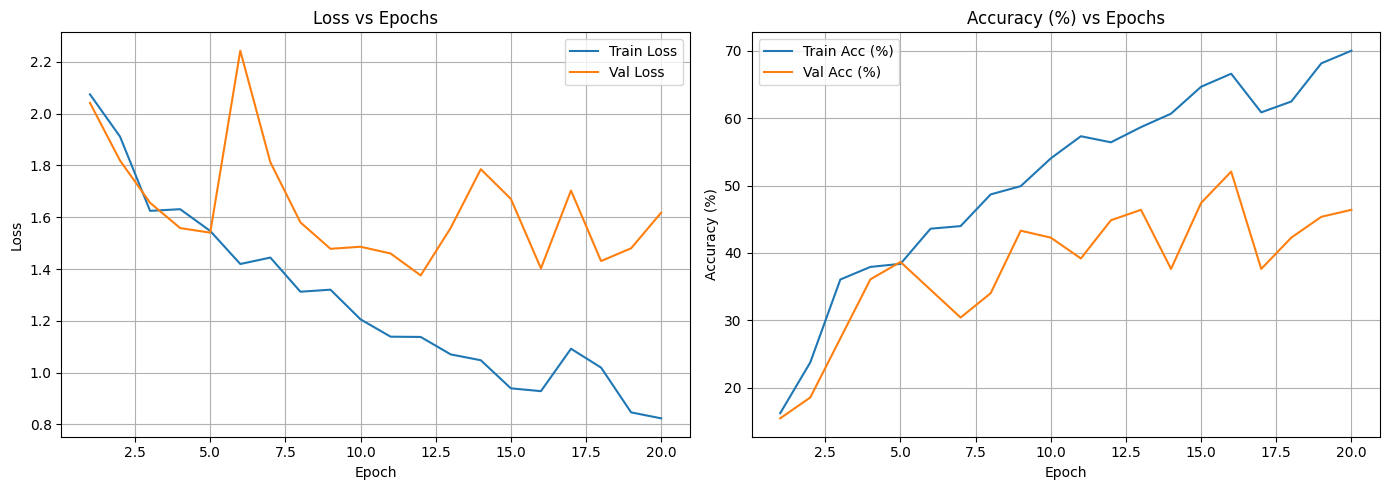

In [15]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in train_accs], label="Train Acc (%)")
plt.plot(epochs, [a * 100 for a in val_accs], label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy (%) vs Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Matrice de confusion


Accuracy globale (VAL): 52.06%
Matrice de confusion (VAL):
 [[ 4  1  1  0  0  0  1  0]
 [ 3 30  1  2 12  4  0  1]
 [ 1  3  5  0  1  1  1  0]
 [ 2  9  3  4  3  3  0  1]
 [ 3 12  0  1 19 10  1  1]
 [ 0  2  0  3  3 15  0  0]
 [ 0  0  0  0  0  0  7  0]
 [ 0  3  0  0  0  0  0 17]]


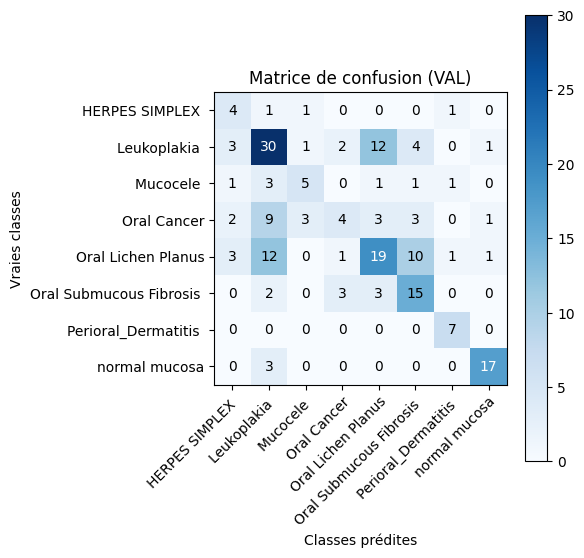


Rapport de classification (VAL):

                          precision    recall  f1-score   support

         HERPES SIMPLEX       0.308     0.571     0.400         7
            Leukoplakia       0.500     0.566     0.531        53
               Mucocele       0.500     0.417     0.455        12
             Oral Cancer      0.400     0.160     0.229        25
      Oral Lichen Planus      0.500     0.404     0.447        47
Oral Submucous Fibrosis       0.455     0.652     0.536        23
    Perioral_Dermatitis       0.700     1.000     0.824         7
           normal mucosa      0.850     0.850     0.850        20

                accuracy                          0.521       194
               macro avg      0.527     0.578     0.534       194
            weighted avg      0.518     0.521     0.506       194

Accuracy par classe (VAL):
  HERPES SIMPLEX : 57.14%
  Leukoplakia : 56.60%
  Mucocele : 41.67%
  Oral Cancer: 16.00%
  Oral Lichen Planus: 40.43%
  Oral Submucous Fibros

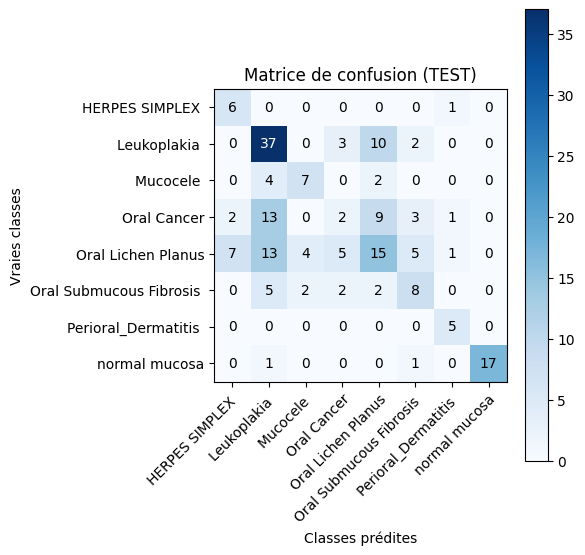


Rapport de classification (TEST):

                          precision    recall  f1-score   support

         HERPES SIMPLEX       0.400     0.857     0.545         7
            Leukoplakia       0.507     0.712     0.592        52
               Mucocele       0.538     0.538     0.538        13
             Oral Cancer      0.167     0.067     0.095        30
      Oral Lichen Planus      0.395     0.300     0.341        50
Oral Submucous Fibrosis       0.421     0.421     0.421        19
    Perioral_Dermatitis       0.625     1.000     0.769         5
           normal mucosa      1.000     0.895     0.944        19

                accuracy                          0.497       195
               macro avg      0.507     0.599     0.531       195
            weighted avg      0.467     0.497     0.468       195

Accuracy par classe (TEST):
  HERPES SIMPLEX : 85.71%
  Leukoplakia : 71.15%
  Mucocele : 53.85%
  Oral Cancer: 6.67%
  Oral Lichen Planus: 30.00%
  Oral Submucous Fibro

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

@torch.no_grad()
def evaluate_and_report(model, loader, class_names, device, title="EVAL"):
    model.eval()
    all_labels, all_preds = [], []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        preds = outputs.argmax(dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    acc = (all_labels == all_preds).mean()
    print(f"\nAccuracy globale ({title}): {acc*100:.2f}%")

    cm = confusion_matrix(all_labels, all_preds)
    print(f"Matrice de confusion ({title}):\n", cm)

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel="Vraies classes",
        xlabel="Classes prédites",
        title=f"Matrice de confusion ({title})"
    )
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.0 if cm.max() > 0 else 0.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

    report = classification_report(all_labels, all_preds, target_names=class_names, digits=3)
    print(f"\nRapport de classification ({title}):\n")
    print(report)

    per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)
    print(f"Accuracy par classe ({title}):")
    for cls, a in zip(class_names, per_class_acc):
        print(f"  {cls}: {a*100:.2f}%")

    return acc, cm


ckpt = torch.load("vgg16_best.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
model.to(device)
model.eval()

_ = evaluate_and_report(model, val_loader, class_names, device, title="VAL")
_ = evaluate_and_report(model, test_loader, class_names, device, title="TEST")